In [1]:
import pandas as pd
import numpy as np
from sklearn import naive_bayes
import os
import sys
import re
import plotly.express as px
import plotly.graph_objects as go
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import pickle
import s3fs

/Users/ldoddi/opt/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
from utils import process_tweet

In [4]:
#Reading the training data file
data = pd.read_csv("s3://twitter-sentiment-laks/processed/sentiment_label_data.csv")
data.sample(5)

,Unnamed: 0,sentiment,text
714691,322663,0,Is sitting at the dmv to get my reg cuz they f...
805518,1469543,1,@SharCarm not a fan of the self pump?
514951,882793,1,I just realised i've got monday training tomor...
714996,1207285,1,@KristenjStewart the trailer for New Moon was ...
714120,1163475,1,@danphasers im writing one later


In [5]:
#cleaning the tweets 
data["tweets"] = data["text"].map(lambda x : process_tweet(x))

In [6]:
#Added column clean_tweet to store te processed tweets 
data["tweets"].sample(10)

383457    @msmcporkchop oh man! i wouldv'e cried 10 time...
658297                                       i'm very cold 
705718    to my surprise and delight, hollie spent a cou...
926356    eddie don't like me cause i do so much crystal...
648728                   pain in my head, my toes, my ties 
234283                             @krftd the site is nice 
108409    @shandrajade it was good, i wish i went to red...
508180    @carolinamama except for that whole land's end...
438394    slightly down. its always weird when im talkin...
785248    had a change of plans...at least i get to enjo...
Name: tweets, dtype: object

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data['tweets'], data['sentiment'], test_size = 0.333, random_state=0)

In [8]:
X_train[0]

'actually loves her life right now '

In [9]:
y_train[0]

1

In [10]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer().fit(X_train)


In [11]:
#vect.get_feature_names()[::10]

In [12]:
X_train_vectorized = vect.transform(X_train)

In [13]:
#Training the model
clfrNB = naive_bayes.MultinomialNB()
clfrNB.fit(X_train_vectorized, y_train)

MultinomialNB()

In [14]:
#Vectorizing and predicting the labels 
X_test_vectorized = vect.transform(X_test)
predicted_labels = clfrNB.predict(X_test_vectorized)

In [15]:
# Metrics to evaluate the model
from sklearn.metrics import roc_auc_score
print("AUC:", roc_auc_score (y_test, predicted_labels))

AUC: 0.7784479901947597


In [16]:
# Confusion Matrix to evaluate for binary classification
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, predicted_labels,labels=clfrNB.classes_ )
confusion_matrix = confusion_matrix.astype(int)
print(confusion_matrix)
# TODO: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html

[[136471  30125]
 [ 43644 122760]]


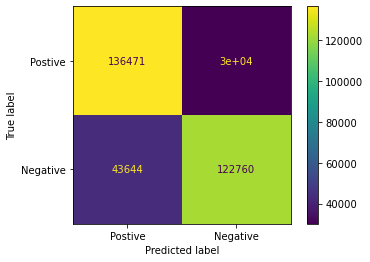

In [17]:
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=['Postive', 'Negative'])
disp.plot()

In [18]:
#Calculating precision, recall, f1_score 
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
print('Precision    : %.3f'%precision_score(y_test, predicted_labels))
print('Recall       : %.3f'%recall_score(y_test, predicted_labels))
print('F1 Score     : %.3f'%f1_score(y_test, predicted_labels))

Precision    : 0.803
Recall       : 0.738
F1 Score     : 0.769


In [19]:
## Loading the model to S3
model_dir='s3://twitter-sentiment-laks/trained_models/'
file_name=model_dir+'naive_bayes_classification.sav'
print(file_name)
fs = s3fs.S3FileSystem(anon=False)
pickle.dump(clfrNB, fs.open(file_name, 'wb'))

s3://twitter-sentiment-laks/trained_models/naive_bayes_classification.sav


In [39]:
# Storing the prediction to csv file
tesla_data.to_csv('../data/output/naive_bayes_sentiment_predictions.csv')